# Lab Notebook 22: Discovery of exoplanets

We will investigate a problem very common in astrophysics, the detection of exoplanets. Exoplanets are planets outside of our solar system that orbit any star other than our sun. By definition exoplanets do not emit light themselves, which makes their detection quite tricky. A common technique is using the transit method, which investigates the brightness of a star over time. If a star possesses a planet orbiting it, the brightness will reduce periodically, when the planet is transiting our view axis.

The data we use here is derived from observations made by the NASA Kepler space telescope.

**Training set (exoTrain.csv):**

5087 rows or observations  
198 columns or features  
Column 1 is the label vector, columns 2 - 3198 are the flux values over time

37 confirmed exoplanet-stars and 5050 non-exoplanet-stars

**Testset (exoTest.csv):**

570 rows or observations  
3198 columns or features  
Column 1 is the label vector, columns 2 - 3198 are the flux values over time

5 confirmed exoplanet-stars and 565 non-exoplanet-stars

We will now preprocess the data and then train a convolutional neural network to find these exoplanets. This is a hard problems since the exoplanets are so rare. As a result, the dataset is very imbalanced.

In [33]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import keras

from keras.models import Sequential #the model is built adding layers one after the other
from keras.layers import Dense #fully connected layers: every output talks to every input
from keras.layers import Dropout #for regularization

from sklearn import metrics as sk_met
from sklearn.metrics import confusion_matrix

## Data acquisition

First, read in the datasets into pandas frames and check out summary statistics via describe.

In [34]:
train_df=pd.read_csv('exoTrain.csv')
test_df=pd.read_csv('exoTest.csv')

print('Training dataset head:',train_df.head())
print('\nTest dataset head:',test_df.head())
print('\nTraining dataset summary statistics:',train_df.describe())

print('\nTest dataset summary statistics:',test_df.describe())

Training dataset head:    LABEL   FLUX.1   FLUX.2   FLUX.3   FLUX.4   FLUX.5   FLUX.6  FLUX.7  \
0      2    93.85    83.81    20.10   -26.98   -39.56  -124.71 -135.18   
1      2   -38.88   -33.83   -58.54   -40.09   -79.31   -72.81  -86.55   
2      2   532.64   535.92   513.73   496.92   456.45   466.00  464.50   
3      2   326.52   347.39   302.35   298.13   317.74   312.70  322.33   
4      2 -1107.21 -1112.59 -1118.95 -1095.10 -1057.55 -1034.48 -998.34   

    FLUX.8  FLUX.9  ...  FLUX.3188  FLUX.3189  FLUX.3190  FLUX.3191  \
0   -96.27  -79.89  ...     -78.07    -102.15    -102.15      25.13   
1   -85.33  -83.97  ...      -3.28     -32.21     -32.21     -24.89   
2   486.39  436.56  ...     -71.69      13.31      13.31     -29.89   
3   311.31  312.42  ...       5.71      -3.73      -3.73      30.05   
4 -1022.71 -989.57  ...    -594.37    -401.66    -401.66    -357.24   

   FLUX.3192  FLUX.3193  FLUX.3194  FLUX.3195  FLUX.3196  FLUX.3197  
0      48.57      92.54      39.32 

Reformat the data into Xtrain, ytrain, Xtest, ytest arrays. Note that the class labels here are 1 and 2, so it is best to subtract 1 so get the more conventional labels 0 and 1.

Plot the flux intensity over time for one example of an exoplant star (eg. index 0) and a non-exoplanet star (eg. index 100). You should see a qualitative difference.

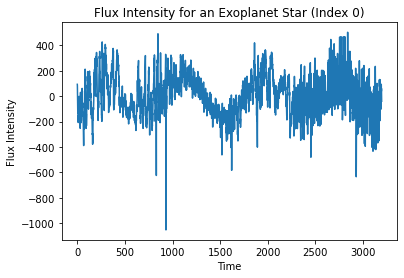

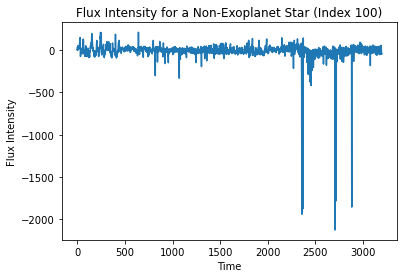

In [35]:
X_train=train_df.iloc[:,1:].values
y_train=train_df.iloc[:,0].values-1

X_test=test_df.iloc[:,1:].values
y_test=test_df.iloc[:,0].values-1

plt.plot(X_train[0])
plt.title('Flux Intensity for an Exoplanet Star (Index 0)')
plt.xlabel('Time')
plt.ylabel('Flux Intensity')
plt.show()

plt.plot(X_train[100])
plt.title('Flux Intensity for a Non-Exoplanet Star (Index 100)')
plt.xlabel('Time')
plt.ylabel('Flux Intensity')
plt.show()

## Data preparation for CNN via FFT, scaling and filtering

In one of the last exercises, we used a convolutional neural network (CNN) to classify the MNIST dataset. The superior performance of this approach comes from the fact that the filters applied to the input gather and aggregate information of regions rather than just looking at individual values or pixels. This can also be of use in our problem, however we have to make some transformations to make the data more suited for the classification task.

The signature we are looking for is a periodic reduction of the light intensity, signaling the transit of an exoplanet. It would be beneficial if we could use this knowledge to extract the relevant information from the raw data. Looking at the Fourier transformed version of the data therefore is a straightforward first step.

1. Apply a **fast fourier transform** (from scipy.fftpack) to Xtrain and Xtest. The result is complex so take the absolute value. Since the fft is symmetric around zero, it is enough to keep the first half of the spectrum only.
2. Use *normalize* from sklearn.preprocessing to make each data observation a vector of length 1. This reduces large values
3. Use *gaussian_filer* (from scipy.ndimage) with gamma=10 to reduce the noise
4. Lastly, use MinMaxScaler from sklearn.preprocessing to keep the data between 0 and 1.

   Show a plot of the data for the same two stars you looked at above after all this processing and filtering.

In [36]:
from scipy.fftpack import fft
from sklearn.preprocessing import normalize, MinMaxScaler
from scipy.ndimage import gaussian_filter

X_train_fft=np.abs(fft(X_train))[:,:X_train.shape[1]//2]
X_test_fft=np.abs(fft(X_test))[:,:X_test.shape[1]//2]

X_train_norm=normalize(X_train_fft,norm='l2')
X_test_norm=normalize(X_test_fft,norm='l2')

X_train_filtered=gaussian_filter(X_train_norm,sigma=10)
X_test_filtered=gaussian_filter(X_test_norm,sigma=10)

scaler=MinMaxScaler()
X_train_scaled=scaler.fit_transform(X_train_filtered)
X_test_scaled=scaler.transform(X_test_filtered)

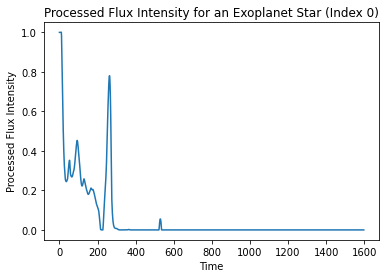

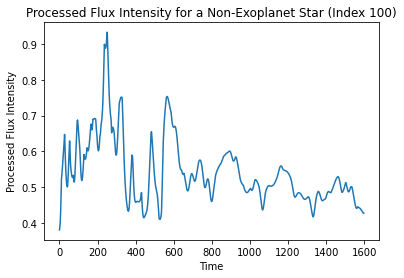

In [37]:
plt.plot(X_train_scaled[0])
plt.title('Processed Flux Intensity for an Exoplanet Star (Index 0)')
plt.xlabel('Time')
plt.ylabel('Processed Flux Intensity')
plt.show()

plt.plot(X_train_scaled[100])
plt.title('Processed Flux Intensity for a Non-Exoplanet Star (Index 100)')
plt.xlabel('Time')
plt.ylabel('Processed Flux Intensity')
plt.show()

## Train a CNN

Use train_test_split to split off 20% of the training data as a validation set (the test data stays unchanged).

In order to use a CNN, we first have to transform our training data, which means reshaping the training set to have the dimensions (4069, 1599, 1), and similar for the test set.

Since the data set is so imbalanced, we will try to use the class_weight parameter to give more weight to the rare class. First, compute the "balanced" class weights. You can use the utility at https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html or write your own. See also https://www.tensorflow.org/tutorials/structured_data/imbalanced_data for how the class_weight dictionary needs to look like.

In [38]:
from sklearn.utils.class_weight import compute_class_weight

X_train,X_val,y_train,y_val=train_test_split(X_train_scaled,y_train,test_size=0.2,random_state=42)

X_train=X_train.reshape((-1,X_train.shape[1],1))
X_val=X_val.reshape((-1,X_val.shape[1],1))
X_test=X_test_scaled.reshape((-1,X_test_scaled.shape[1], 1))

class_weights=compute_class_weight('balanced',classes=np.unique(y_train),y=y_train)
class_weight_dict={i:class_weights[i] for i in range(len(class_weights))}

**Proposed structure of the CNN:**

1. A 1d convolution layer (Conv1D) with 16 filters, input shape matching the dataset, kernel_size=3, activation = 'relu', kernel_regularizer='l2', padding='same'.
2. A max pooling layer (MaxPooling1D) with pool_size=2 and strides =2
3. A 30% dropout layer
4. A flatten operation
5. A dense layer with 32 neurons
6. a 50% dropout layer
7. A final output layer with output dimension 2 and sigmoid activation for classification. The appropriate loss function is then *keras.losses.SparseCategoricalCrossentropy()*

Use the adam optimizer with learning rate = 0.01


In [39]:
from keras.layers import Conv1D, MaxPooling1D, Flatten
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

model = Sequential([
    Conv1D(16, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01), padding='same', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2, strides=2),
    Dropout(0.3),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  
])

model.compile(optimizer=Adam(learning_rate=0.01), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

C:\Users\antho\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


**Try training the model for 20 epochs** Remember to pass the "validation_data" and the "class_weight" to model.fit(). 

In [40]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_val, y_val),
                    class_weight=class_weight_dict,
                    verbose=1)

Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7849 - loss: 6.2972 - val_accuracy: 0.9990 - val_loss: 0.0319
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6527 - loss: 0.6485 - val_accuracy: 0.0079 - val_loss: 0.9274
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.1222 - loss: 0.6630 - val_accuracy: 0.0128 - val_loss: 0.7638
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1298 - loss: 0.7447 - val_accuracy: 0.9892 - val_loss: 0.6135
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7555 - loss: 0.6137 - val_accuracy: 0.9971 - val_loss: 0.1116
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6459 - loss: 0.7755 - val_accuracy: 0.9980 - val_loss: 0.0174
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6272 - loss: 0.5593 - val_accuracy: 0.9548 - val_loss: 0.6563
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4983 - loss: 0.7243 - val_accu

Plot the training and validation loss and accuracy versus epochs. Have you trained enough?

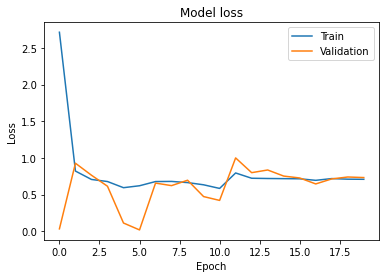

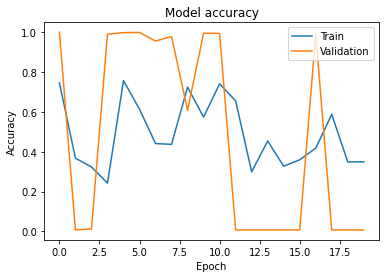

In [47]:
plt.plot(history.history['loss'],label='Train')
plt.plot(history.history['val_loss'],label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'],label='Train')
plt.plot(history.history['val_accuracy'],label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

#### Loss converges for both at around 0.7, and accuracy does not converge and remains apart. This implies that our model may be over or underfitting to the training data, which would mean that increasing train size will not help, and that further scaling or regularization might be more helpful.

Inspect the confusion matrix for the CNN on the test data. Note that in keras, calling model.predict gives you the output probabilities, not the class label. You need to compute that from the probabilities.

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


Text(0, 0.5, 'True Labels')

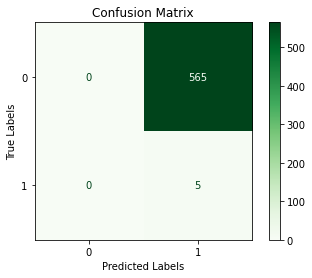

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions=model.predict(X_test)
y_pred=np.argmax(predictions,axis=1)
cm=confusion_matrix(y_test,y_pred)

disp=ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

Compute accuracy, precision, and recall metrics for train and test data. 

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

train_predictions=model.predict(X_train)
train_pred_labels=np.argmax(train_predictions, axis=1)

train_accuracy = accuracy_score(y_train, train_pred_labels)
train_precision = precision_score(y_train, train_pred_labels)
train_recall = recall_score(y_train, train_pred_labels)


test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)

print('Training Data:')
print(f'Accuracy: {train_accuracy:.4f}')
print(f'Precision: {train_precision:.4f}')
print(f'Recall: {train_recall:.4f}')

print('\nTest Data:')
print(f'Accuracy: {test_accuracy:.4f}')
print(f'Precision: {test_precision:.4f}')
print(f'Recall: {test_recall:.4f}')

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Training Data:
Accuracy: 0.0071
Precision: 0.0071
Recall: 1.0000

Test Data:
Accuracy: 0.0088
Precision: 0.0088
Recall: 1.0000


**Questions:**

1. Which metric, in your opinion, is most useful for the present problem? Do you have a useful classifier?
2. Re-train the network a few times, and comment on the results.

#### 1. Recall is clearly the most useful because there are very few exoplanets. This works very well for recall so it is useful however the accuracy and precision are very low, which could be improved on.

### 2.

C:\Users\antho\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9595 - loss: 1.2963 - val_accuracy: 0.9980 - val_loss: 0.2524
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9391 - loss: 0.5114 - val_accuracy: 0.9971 - val_loss: 0.1620
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9527 - loss: 0.3796 - val_accuracy: 0.9990 - val_loss: 0.0526
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9665 - loss: 0.3191 - val_accuracy: 0.9990 - val_loss: 0.0903
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9661 - loss: 0.2226 - val_accuracy: 1.0000 - val_loss: 0.0415
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9486 - loss: 0.3444 - val_accuracy: 1.0000 - val_loss: 0.1076
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9512 - loss: 0.2378 - val_accuracy: 0.9882 - val_loss: 0.0647
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9488 - loss: 0.1860 - val_accu

C:\Users\antho\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


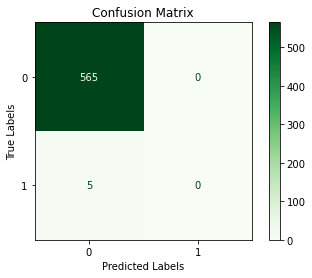

In [52]:
model = Sequential([
    Conv1D(16, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01), padding='same', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2, strides=2),
    Dropout(0.3),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  
])
#different learning rate
model.compile(optimizer=Adam(learning_rate=0.001), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_val, y_val),
                    class_weight=class_weight_dict,
                    verbose=1)
predictions=model.predict(X_test)
y_pred=np.argmax(predictions,axis=1)
cm=confusion_matrix(y_test,y_pred)

disp=ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
train_predictions=model.predict(X_train)
train_pred_labels=np.argmax(train_predictions, axis=1)

train_accuracy = accuracy_score(y_train, train_pred_labels)
train_precision = precision_score(y_train, train_pred_labels)
train_recall = recall_score(y_train, train_pred_labels)


test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)

print('Training Data:')
print(f'Accuracy: {train_accuracy:.4f}')
print(f'Precision: {train_precision:.4f}')
print(f'Recall: {train_recall:.4f}')

print('\nTest Data:')
print(f'Accuracy: {test_accuracy:.4f}')
print(f'Precision: {test_precision:.4f}')
print(f'Recall: {test_recall:.4f}')

Epoch 1/20


C:\Users\antho\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8650 - loss: 3.1691 - val_accuracy: 0.9990 - val_loss: 0.0954
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8366 - loss: 0.5283 - val_accuracy: 0.9990 - val_loss: 0.0594
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8643 - loss: 0.3683 - val_accuracy: 0.9980 - val_loss: 0.0323
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6074 - loss: 0.8015 - val_accuracy: 0.2407 - val_loss: 0.9452
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7455 - loss: 0.3990 - val_accuracy: 0.9990 - val_loss: 0.0209
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8432 - loss: 0.4155 - val_accuracy: 1.0000 - val_loss: 0.0124
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7854 - loss: 0.4233 - val_accuracy: 0.9892 - val_loss: 0.0561
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8759 - loss: 0.2431 - val_accuracy: 0.999

C:\Users\antho\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


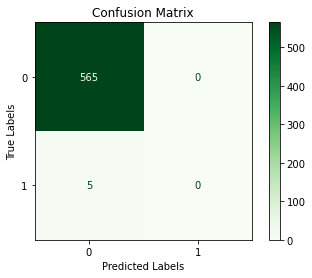

In [53]:
#smaller model
model = Sequential([
    Conv1D(8, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01), padding='same', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2, strides=2),
    Dropout(0.3),
    Flatten(),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')  
])

model.compile(optimizer=Adam(learning_rate=0.01), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_val, y_val),
                    class_weight=class_weight_dict,
                    verbose=1)
predictions=model.predict(X_test)
y_pred=np.argmax(predictions,axis=1)
cm=confusion_matrix(y_test,y_pred)

disp=ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
train_predictions=model.predict(X_train)
train_pred_labels=np.argmax(train_predictions, axis=1)

train_accuracy = accuracy_score(y_train, train_pred_labels)
train_precision = precision_score(y_train, train_pred_labels)
train_recall = recall_score(y_train, train_pred_labels)


test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)

print('Training Data:')
print(f'Accuracy: {train_accuracy:.4f}')
print(f'Precision: {train_precision:.4f}')
print(f'Recall: {train_recall:.4f}')

print('\nTest Data:')
print(f'Accuracy: {test_accuracy:.4f}')
print(f'Precision: {test_precision:.4f}')
print(f'Recall: {test_recall:.4f}')

#### Making slight changes and re-running hugely increases accuracy however the recall for test data is 0, which is much less useful than before.

## Train a RNN

Our time series data is in principle amenable to treatment by an RNN. To this end, we **return to the original, unprocessed data** without the FFT and filtering. 

Use again train_test_split to split off 20% of the training data as a validation set (the test data stays unchanged). Then reshape the features so that X_train for instance has the shape (4069, 3197, 1). 

In [54]:
X_train_rnn,X_val_rnn,y_train_rnn,y_val_rnn=train_test_split(X_train,y_train,test_size=0.2,random_state=42)

X_train_rnn=X_train_rnn.reshape((X_train_rnn.shape[0],X_train_rnn.shape[1],1))
X_val_rnn=X_val_rnn.reshape((X_val_rnn.shape[0],X_val_rnn.shape[1],1))
X_test_rnn=X_test.reshape((X_test.shape[0],X_test.shape[1],1))

Let's build a sequential network with 

1) a SimpleRNN layer of 16 of 32 neurons.
2) a dropout layer with 20%
3) a final dense layer with sigmoid activation as before for classification

Everything else can be the same as the CNN, including the class weights.

**Try training the RNN for 10 epochs**

In [55]:
from keras.layers import SimpleRNN

model_rnn = Sequential([
    SimpleRNN(32, input_shape=(X_train_rnn.shape[1], 1)),  
    Dropout(0.2),  
    Dense(1, activation='sigmoid')  
])

model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_rnn = model_rnn.fit(X_train_rnn, y_train_rnn, 
                            epochs=10, 
                            validation_data=(X_val_rnn, y_val_rnn), 
                            class_weight=class_weight_dict, 
                            verbose=1)

C:\Users\antho\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 50s 455ms/step - accuracy: 0.9702 - loss: 0.6111 - val_accuracy: 0.9988 - val_loss: 0.2708
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - accuracy: 0.9968 - loss: 0.5479 - val_accuracy: 0.9398 - val_loss: 0.3697
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 48s 472ms/step - accuracy: 0.9724 - loss: 0.3215 - val_accuracy: 0.9926 - val_loss: 0.1338
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 47s 466ms/step - accuracy: 0.9711 - loss: 0.4585 - val_accuracy: 1.0000 - val_loss: 0.1090
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 50s 487ms/step - accuracy: 0.9681 - loss: 0.2985 - val_accuracy: 0.9988 - val_loss: 0.0791
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 48s 465ms/step - accuracy: 0.9965 - loss: 0.2392 - val_accuracy: 0.9975 - val_loss: 0.2076
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 47s 461ms/step - accuracy: 0.9771 - loss: 0.2057 - val_accuracy: 1.0000 - val_loss: 0.0784
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 47s 459ms/step - accuracy: 0.9938 - loss: 0

Plot again training and validation loss and accuracy.

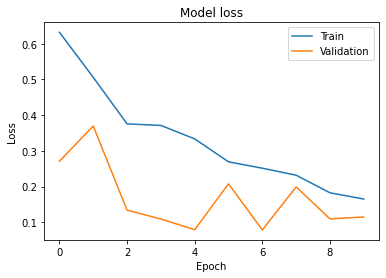

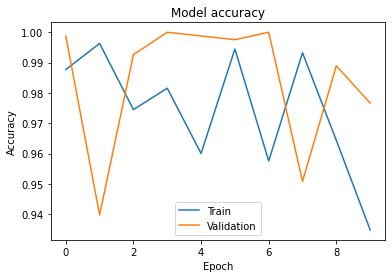

In [59]:
plt.plot(history_rnn.history['loss'],label='Train')
plt.plot(history_rnn.history['val_loss'],label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history_rnn.history['accuracy'],label='Train')
plt.plot(history_rnn.history['val_accuracy'],label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

And the confusion matrix

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step


Text(0, 0.5, 'True Labels')

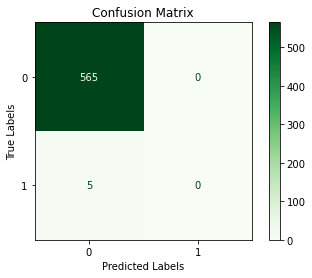

In [57]:
predictions=model_rnn.predict(X_test)
y_pred=np.argmax(predictions,axis=1)
cm=confusion_matrix(y_test,y_pred)

disp=ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

And the final scores. How is the RNN doing in our classification task? Is the RNN or CNN better?

In [58]:
train_predictions=model_rnn.predict(X_train)
train_pred_labels=np.argmax(train_predictions,axis=1)

train_accuracy=accuracy_score(y_train,train_pred_labels)
train_precision=precision_score(y_train,train_pred_labels)
train_recall=recall_score(y_train,train_pred_labels)


test_accuracy=accuracy_score(y_test,y_pred)
test_precision=precision_score(y_test,y_pred)
test_recall=recall_score(y_test,y_pred)

print('Training Data:')
print(f'Accuracy: {train_accuracy:.4f}')
print(f'Precision: {train_precision:.4f}')
print(f'Recall: {train_recall:.4f}')

print('\nTest Data Metrics:')
print(f'Accuracy: {test_accuracy:.4f}')
print(f'Precision: {test_precision:.4f}')
print(f'Recall: {test_recall:.4f}')

128/128 ━━━━━━━━━━━━━━━━━━━━ 16s 121ms/step
Training Data:
Accuracy: 0.9929
Precision: 0.0000
Recall: 0.0000

Test Data Metrics:
Accuracy: 0.9912
Precision: 0.0000
Recall: 0.0000


C:\Users\antho\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\antho\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Since recall is of great importance here as exoplanets are rare, the cnn model is better, however as can be seen doing re-runs, even the cnn model misses all of the test exoplanets, so neither model works very well.